In [13]:
import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [ ]:
load_dotenv()
print(os.getenv('HF_TOKEN'))
print(os.getenv('HF_TOKEN2'))

os.environ['HF_TOKEN2'] = os.getenv('HF_TOKEN2')

print(os.environ['HF_TOKEN'])
print(os.environ['HF_TOKEN2'])

In [16]:
hf_token = os.environ['HF_TOKEN2']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [17]:
%matplotlib inline

In [18]:
# Load in the same dataset as last time

items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|███████████████████████████████████████████████████████████████████████████████| 95/95 [00:23<00:00,  3.96it/s]


Completed Appliances with 28,625 datapoints in 0.5 mins


In [9]:
# Look for a familiar item..
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


In [19]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [20]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!

Loading dataset Appliances


100%|███████████████████████████████████████████████████████████████████████████████| 95/95 [00:23<00:00,  4.01it/s]


Completed Appliances with 28,625 datapoints in 0.4 mins
Loading dataset Musical_Instruments


100%|█████████████████████████████████████████████████████████████████████████████| 214/214 [00:56<00:00,  3.77it/s]


Completed Musical_Instruments with 66,829 datapoints in 1.0 mins


In [21]:
print(f"A grand total of {len(items):,} items")

A grand total of 95,454 items


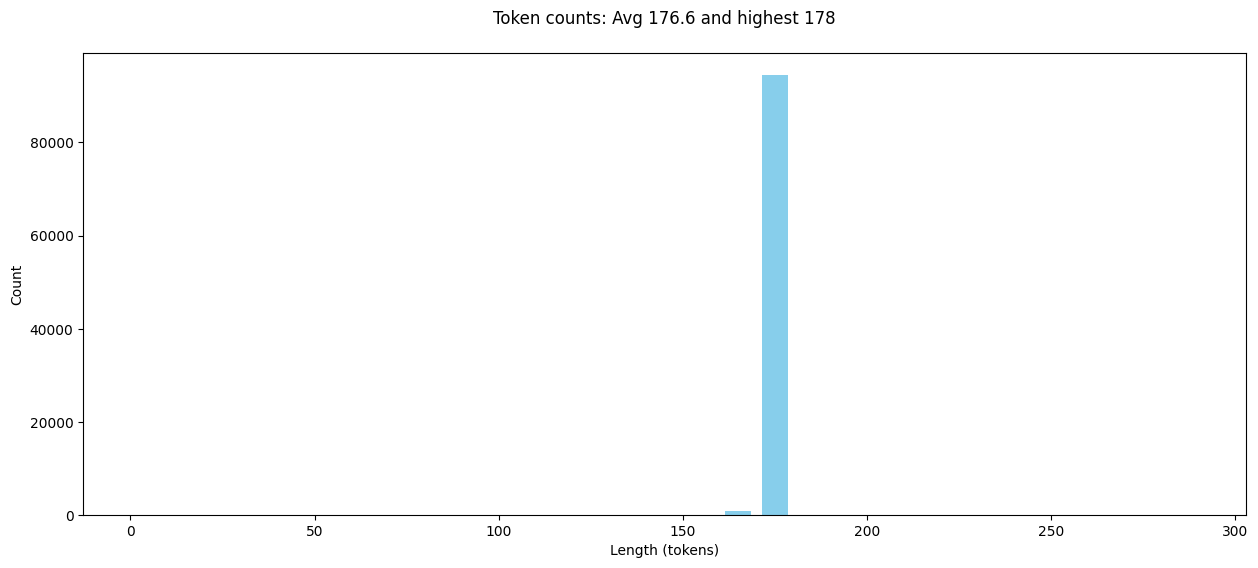

In [22]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

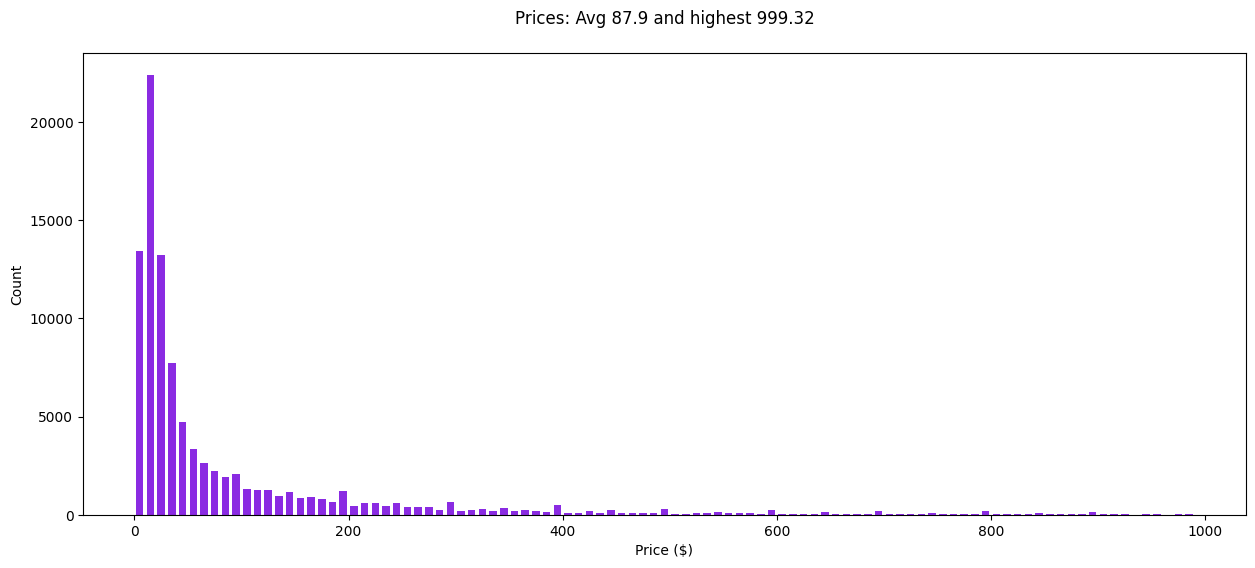

In [23]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

Counter({'Musical_Instruments': 66829, 'Appliances': 28625})
[28625, 66829]


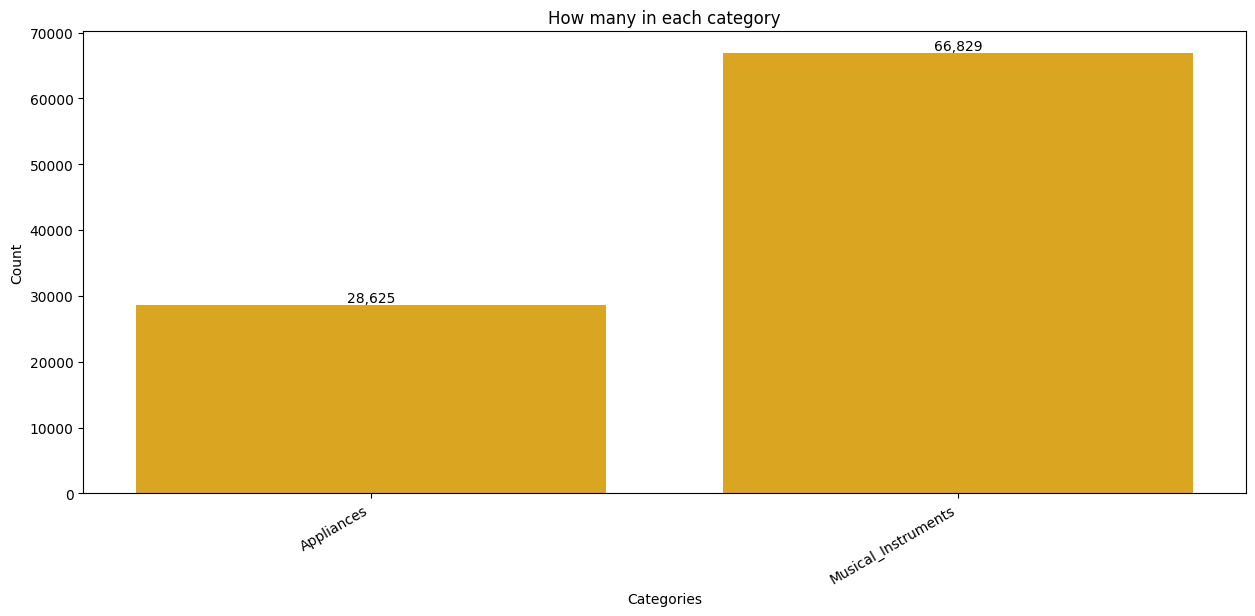

In [24]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

print(category_counts)
print(counts)

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [25]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [26]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility

# print(len(slots[10]))
# weights = np.array([1 if item.category=='Automotive' else 5 for item in slots[10]])
# print(weights)
# weights = weights / np.sum(weights)
# print(weights)


np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 76,212 items in the sample


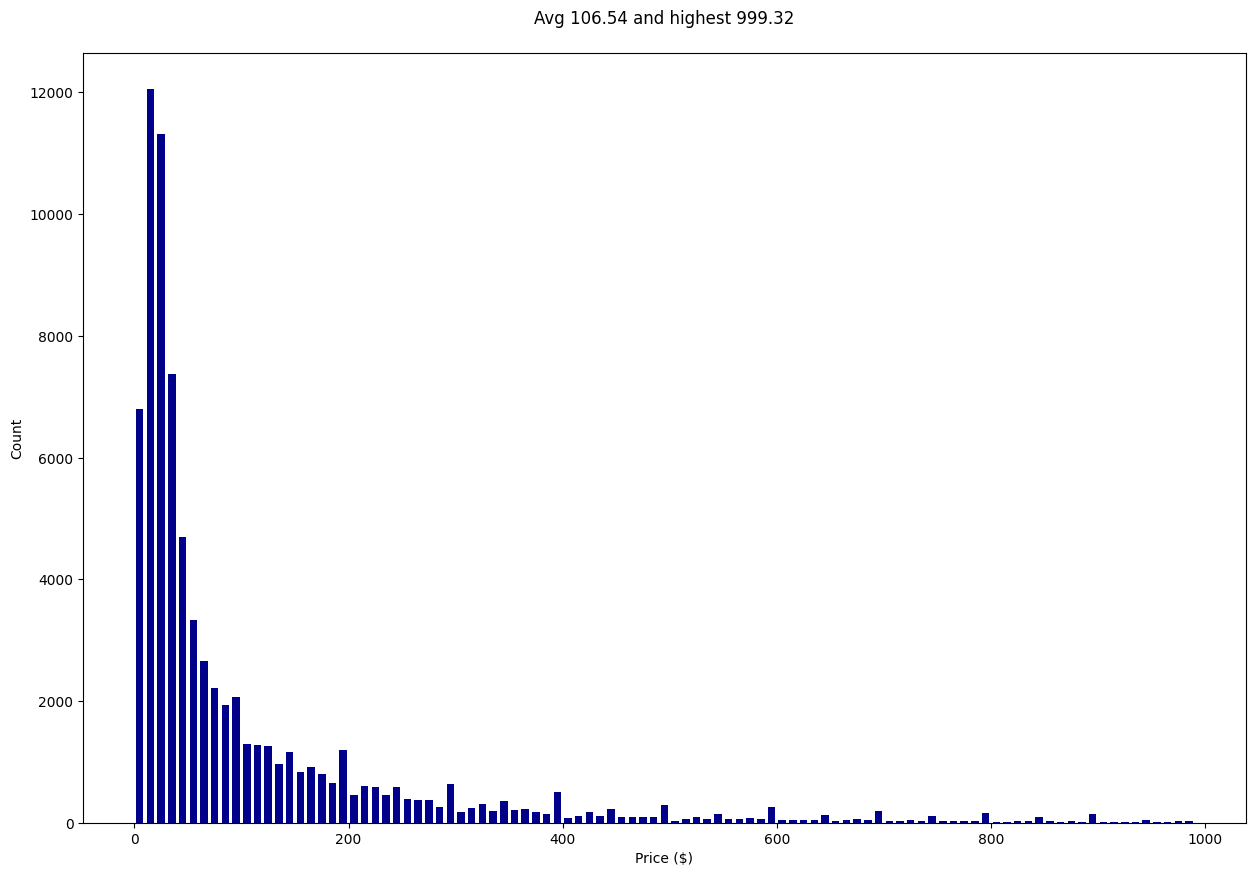

In [27]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

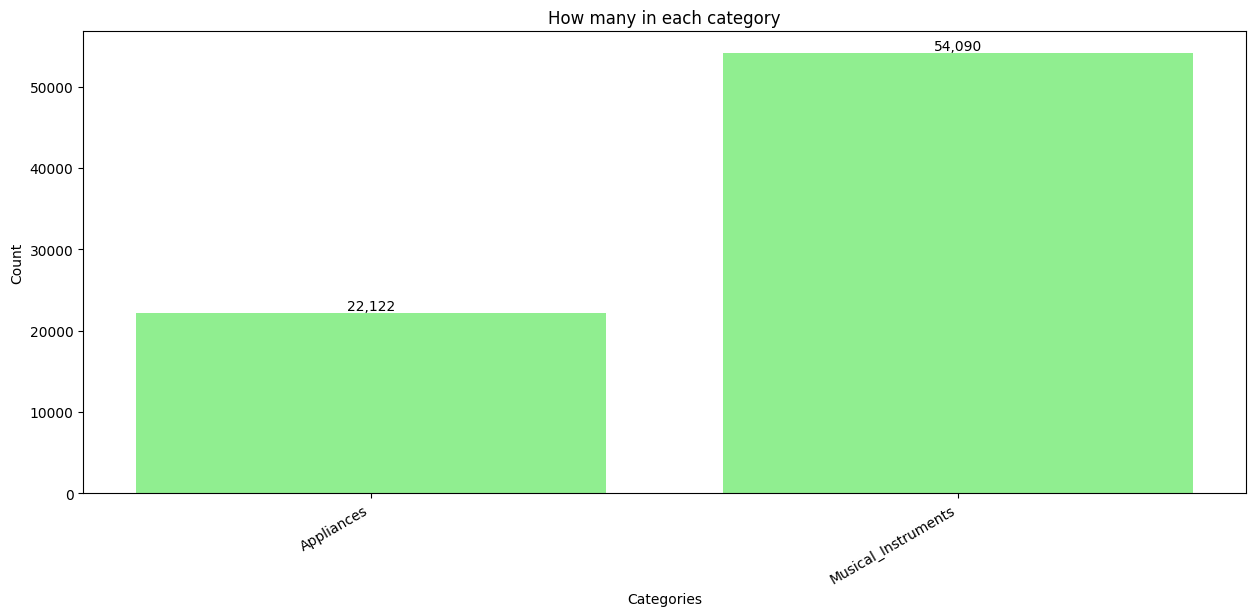

In [28]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

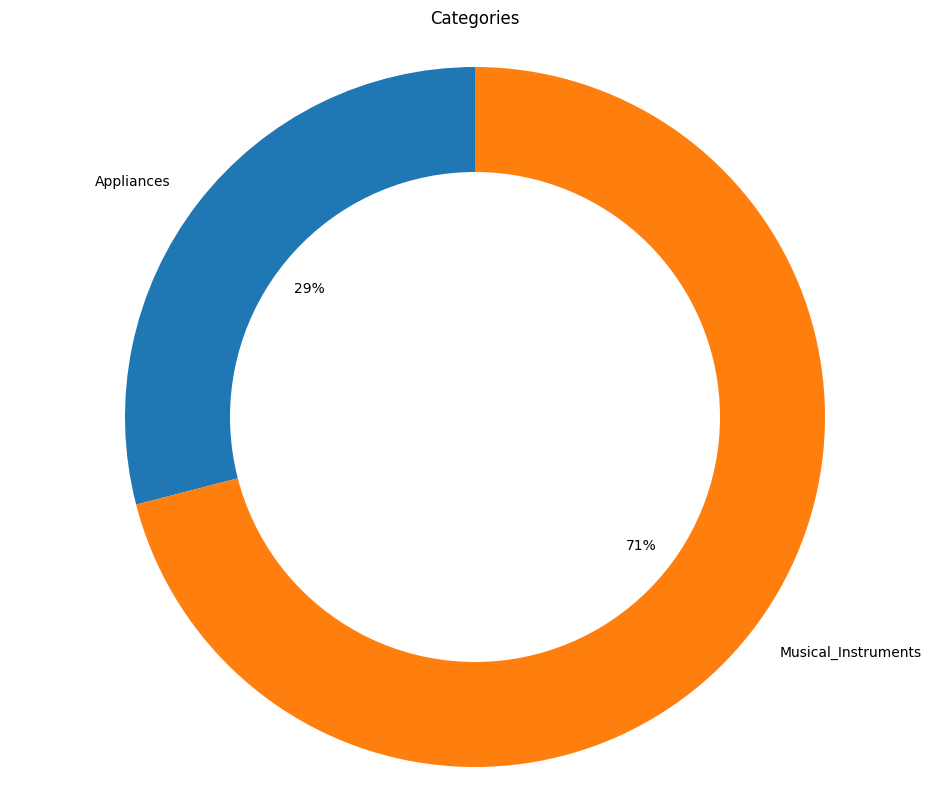

In [29]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

# Dataset Curated

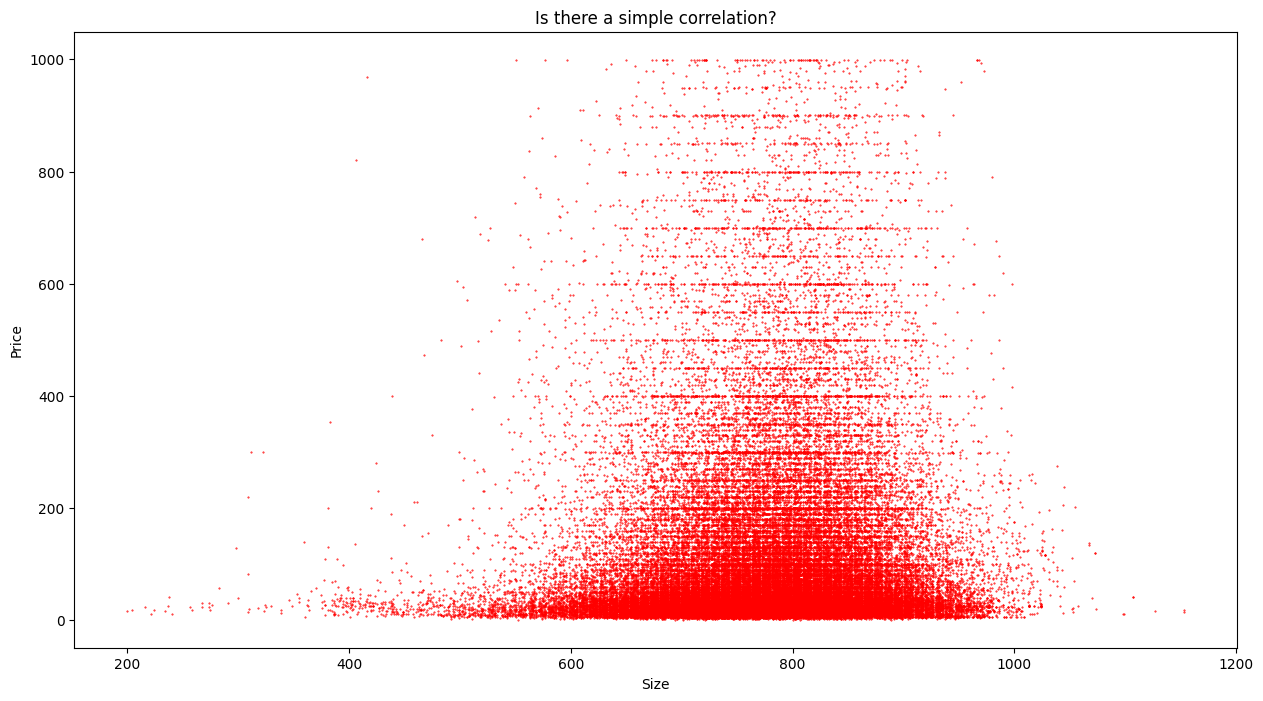

In [30]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [31]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [32]:
report(sample[10])

How much does this cost to the nearest dollar?

BERRYZILLA Farmhouse Style Wash and Dry Decal Modern Trendy Cute Washer Quote for Home Apartment Washing Machine Dryer Laundry Room
Die Cut Decal- Color In WHITE, Dit Cut, No Background, No Black Background. Made In The USA Each Decal is 5 tall x 10 wide Color In WHITE, Dit Cut, No Background, No Black Background. Made of 7 Years Premium quality Outdoor Vinyl Material, waterproof, self-adhesive, and removable. Brand BERRYZILLA, Dimensions LxWxH 10 x 5 x 0.01 inches, Surface Recommendation flat, Material Vinyl, Theme Quote, Special Feature Waterproof, Pieces 1, Style Farmhouse, Age Range (Description) Adult, Installation Type Self-Adhesive, Reusability Single

Price is $2.00
[355, 2968, 11579, 271, 7117, 374, 400, 17, 13, 410]
['us', 'ability', ' Single', '\n\n', 'Price', ' is', ' $', '2', '.', '00']


# Observation

In [33]:
random.seed(42)
random.shuffle(sample)
# train = sample[:400_000]
# test = sample[400_000:402_000]
# train = sample[:25000]
# test = sample[25000:28000]
train = sample[:74_000]
test = sample[74_000:76_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 74,000 items and test set of 2,000 items


In [34]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Movo Wireless Microphone System with Plug-on XLR Transmitter Adapter and Portable Receiver - Converts Self Powered Shotgun Mics, Lavs, Dynamic Microphones to Wireless - for Stage, Film
CRYSTAL CLEAR SOUND Transmitter picks up crisp audio signals and broadcasts them with zero interference POWERFUL TRANSMISSION Plug-in wireless transmitter broadcasts audio signal up to 300 feet away without obstructions 1-YEAR WARRANTY We’ve got your back! Our products are designed to ease your technical woes, not add to them. Our friendly US-Based support team is here to help MOUNT IT YOUR WAY Receiver can be clipped onto belt or attached to DSLR cameras and phone video rigs via cold shoe mount INCLUDES TXLR Wireless Plug-in Transmitter, RX Wireless Receiver Weight 1.28 pounds,

Price is $110.00


In [35]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Washer Lid Strike Compatible with Whirlpool Maytag, Washer Door Lock
Product Overview New Upgrade Washer Lid lock.High-quality replacement part for Whirlpool Maytag Maytag Washer Door Lock. High-quality Products It has a durable plastic construction for reliable use. And fully tested to ensure long-term effective operation. Replaceable Models Washer Lid Strike accurately replaces the parts of models Compatible Brands Washer Lid Strike compatible with some washers from Whirlpool, Maytag, Kenmore. After-sale Service For any quality issues, you can request to send a new one or a full refund. What you buy is not only a product, but also a whole set of our after-sales service. Any questions, just one email, we will always solve for you within 12 hours. Exterior Finish Plastic, Brand G

Price is $


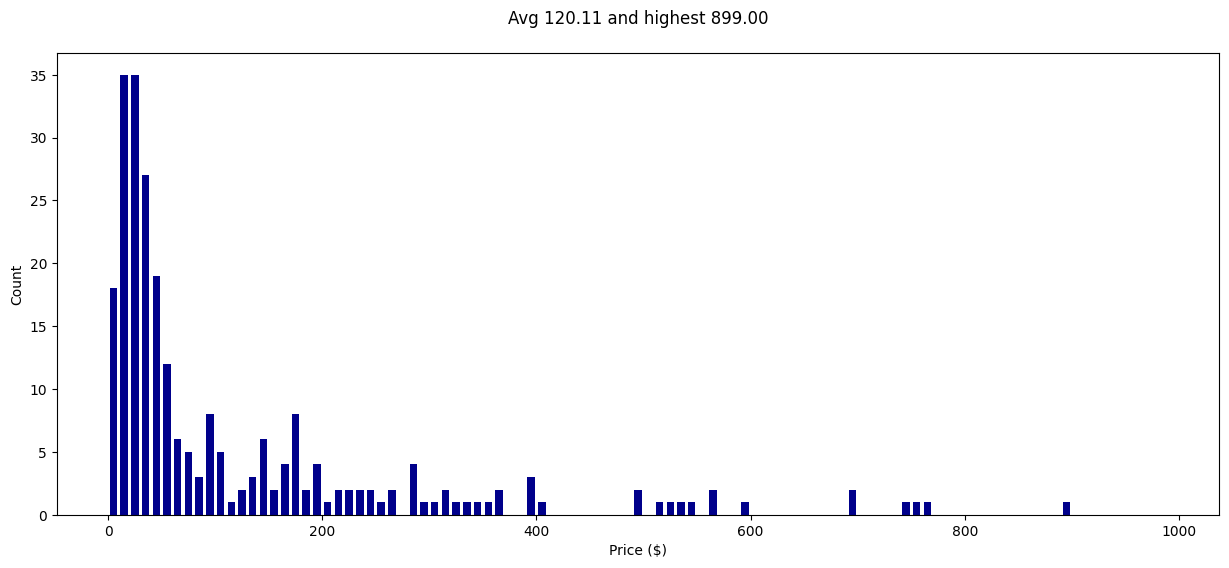

In [36]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [37]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [38]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username

HF_USER = "zeeshanhanif"
DATASET_NAME = f"{HF_USER}/product-pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/74 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/zeeshanhanif/product-pricer-data/commit/08b1c431fedcfdee9d433b19642e7bfcdcaa8572', commit_message='Upload dataset', commit_description='', oid='08b1c431fedcfdee9d433b19642e7bfcdcaa8572', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/zeeshanhanif/product-pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='zeeshanhanif/product-pricer-data'), pr_revision=None, pr_num=None)

In [41]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('my-train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('my-test.pkl', 'wb') as file:
    pickle.dump(test, file)

In [42]:


from huggingface_hub import HfApi

api = HfApi()
user_info = api.whoami()
print(user_info)

{'type': 'user', 'id': '65fa7fc18a09237143ef762d', 'name': 'zeeshanhanif', 'fullname': 'Zeeshan Hanif', 'email': 'zeeshanhanif@gmail.com', 'emailVerified': True, 'canPay': False, 'periodEnd': 1743465599, 'isPro': False, 'avatarUrl': '/avatars/e5bae9bf364ed969c47e6f662ad66fdb.svg', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'demo2', 'role': 'write', 'createdAt': '2025-02-14T06:53:25.807Z'}}}
